In [180]:
import pandas as pd
import numpy as np
import seaborn as sns

In [181]:
inputdir = "../../data/derived/"
inputdir_for_iv = "../../data/raw/"

In [182]:
#Import the data
data17 = pd.read_csv(inputdir + "chfs2017data.csv")
data15 = pd.read_csv(inputdir + "chfs2015data.csv")
data13 = pd.read_csv(inputdir + "chfs2013data.csv")
data11 = pd.read_csv(inputdir + "chfs2011data.csv")
bank_density_data = pd.read_csv(inputdir_for_iv + "Bank_density_data.csv")

In [183]:
data17.head()

,hhid,hhid_2011,hhid_2013,hhid_2015,hhid_2017,stock_values,pline,hhead,education_level,prov_code,...,married,stock_account,health,unemployment,own_house,happiness,rural_household_registration,credit_constraints,econ_fin_info_concern,risk_preference
0,2017000001,NaN,NaN,NaN,2017000001,NaN,2,1.0,1.0,44,...,1,0.0,3.0,0,1,1.0,1,0,1.0,0.0
1,2017000001,NaN,NaN,NaN,2017000001,NaN,1,NaN,1.0,44,...,1,0.0,3.0,0,1,1.0,1,0,1.0,0.0
2,2013013417,NaN,2.013013e+09,2.015018e+09,2017000002,NaN,2,NaN,2.0,35,...,1,0.0,2.0,0,1,0.0,0,0,NaN,NaN
3,2013013417,NaN,2.013013e+09,2.015018e+09,2017000002,NaN,3,NaN,1.0,35,...,0,0.0,2.0,1,1,0.0,0,0,NaN,NaN
4,2013013417,NaN,2.013013e+09,2.015018e+09,2017000002,NaN,4,NaN,5.0,35,...,0,0.0,4.0,0,1,0.0,0,0,NaN,NaN


# Data cleaning

<AxesSubplot:>

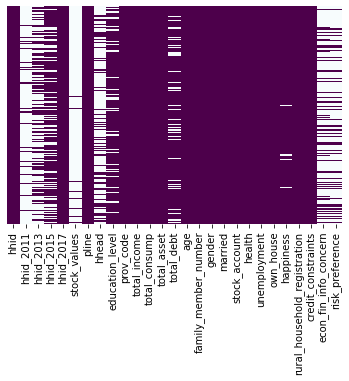

In [184]:
#Data visualization for the missing values
sns.heatmap(data17.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [185]:
data17.isna().sum()

hhid                                 0
hhid_2011                       110864
hhid_2013                        70872
hhid_2015                        38868
hhid_2017                            0
stock_values                    120378
pline                                0
hhead                            87001
education_level                  17948
prov_code                            0
total_income                         0
total_consump                        0
total_asset                          0
total_debt                       18867
age                                 47
family_member_number                11
gender                               8
married                              0
stock_account                      385
health                              88
unemployment                         0
own_house                            0
happiness                         1415
rural_household_registration         0
credit_constraints                   0
econ_fin_info_concern    

In [186]:
#Row numbers for chfs 2017 data
data17.shape[0]

127012

**Deal with missing values of stock-related variables**

In [187]:
data17["stock_values"] = np.where(data17["stock_account"] == 0, 0, data17["stock_values"])

In [188]:
data17["stock_values"] = np.where((data17["stock_values"] == ".d") | 
                                  (data17["stock_values"] == ".r") | 
                                  (data17["stock_values"] == ".n") |
                                  (data17["stock_values"] == ".e"), 
                                  ".", data17["stock_values"])
data17["stock_values"] = np.where(data17["stock_values"] == ".", -1, data17["stock_values"])
#Change the type of dependent variable
data17["stock_values"] = data17["stock_values"].astype(float)
#Delete missing values
data17 = data17.drop(data17[data17['stock_values'] == -1].index)

In [189]:
#Delete unneeded variable
del data17["stock_account"]

In [190]:
#Since my research question is focused on the household level, I only need one data per household.
#That is, the data of the head of the household.
data17 = data17.dropna(subset = ['hhead'])
del data17['hhead']

In [191]:
data15.head()

,hhid_2015,econ_fin_info_concern_2015,risk_preference_2015
0,2015000001,1.0,0.0
1,2015000002,3.0,2.0
2,2015000003,1.0,0.0
3,2015000004,3.0,4.0
4,2015000005,0.0,0.0


In [192]:
data13.head()

,hhid_2013,econ_fin_info_concern_2013,risk_preference_2013
0,2013000001,1.0,1.0
1,2013000002,2.0,1.0
2,2013000003,2.0,0.0
3,2013000004,3.0,0.0
4,2013000005,2.0,2.0


In [193]:
data11.head()

,hhid_2011,risk_preference_2011
0,201100001,0.0
1,201100002,0.0
2,201100003,0.0
3,201100004,0.0
4,201100005,0.0


In [194]:
data17['hhid_2015'] = np.where(data17["hhid_2015"].isnull() == True, -1, data17["hhid_2015"])
data17['hhid_2013'] = np.where(data17["hhid_2013"].isnull() == True, -1, data17["hhid_2013"])
data17['hhid_2011'] = np.where(data17["hhid_2011"].isnull() == True, -1, data17["hhid_2011"])
data17['hhid_2015'] = data17['hhid_2015'].astype(int)
data17['hhid_2013'] = data17['hhid_2013'].astype(int)
data17['hhid_2011'] = data17['hhid_2011'].astype(int)

You can observe a large number of missing values in `econ_fin_info_concern` and `risk_preference` in data17 because only new respondents were interviewed in these two related questions in the 2017 survey. Therefore, I need to merge the previous data and fill in the missing values.

In addition, I will merge the data that contains the instrumental variable. The instrumental variable I chose is the density of banks in each province and the formula is the number of banks in each province / area of each province.

**IV data sources**

China Banking and Insurance Regulatory Commission (Number of banks): https://xkz.cbirc.gov.cn/jr/

Wikipedia (Area of each province): https://zh.wikipedia.org/wiki/%E4%B8%AD%E5%8D%8E%E4%BA%BA%E6%B0%91%E5%85%B1%E5%92%8C%E5%9B%BD%E7%9C%81%E7%BA%A7%E8%A1%8C%E6%94%BF%E5%8C%BA%E5%9C%9F%E5%9C%B0%E9%9D%A2%E7%A7%AF%E5%88%97%E8%A1%A8

In [195]:
data1 = pd.merge(data17, data15, on = 'hhid_2015', how = 'outer')
data2 = pd.merge(data1, data13, on = 'hhid_2013', how = 'outer')
data3 = pd.merge(data2, data11, on = 'hhid_2011', how = 'outer')
#Merge the csv file which contains the instrumental variable I needed
data = pd.merge(data3, bank_density_data, on = 'prov_code', how = 'outer')
#The merge method I used produces a lot of na values, remove them.
data = data.dropna(subset = ['hhid'])
#The merge method I used also produces a lot of duplicate values, so I need to remove these duplicates.
data = data.drop_duplicates(subset = ['hhid'], keep = 'first')

In [196]:
data['econ_fin_info_concern'] = np.where(data["econ_fin_info_concern"].isnull() == True, 
                                         data["econ_fin_info_concern_2015"], data["econ_fin_info_concern"])
data['econ_fin_info_concern'] = np.where(data["econ_fin_info_concern"].isnull() == True, 
                                         data["econ_fin_info_concern_2013"], data["econ_fin_info_concern"])

In [197]:
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2015"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2013"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2011"], 
                                   data["risk_preference"])

In [198]:
#Delete unneeded variables
del data["hhid_2017"]
del data["hhid_2015"]
del data["hhid_2013"]
del data["hhid_2011"]
del data["econ_fin_info_concern_2015"]
del data["econ_fin_info_concern_2013"]
del data["risk_preference_2015"]
del data["risk_preference_2013"]
del data["risk_preference_2011"]
del data["prov_code"]
del data["bank_number"]
del data["prov_area"]

In [199]:
data.isna().sum()

hhid                               0
stock_values                    1257
pline                              0
education_level                   52
total_income                       0
total_consump                      0
total_asset                        0
total_debt                      8274
age                               10
family_member_number               3
gender                             1
married                            0
health                             9
unemployment                       0
own_house                          0
happiness                        454
rural_household_registration       0
credit_constraints                 0
econ_fin_info_concern             44
risk_preference                 3677
bank_density                       0
dtype: int64

<AxesSubplot:>

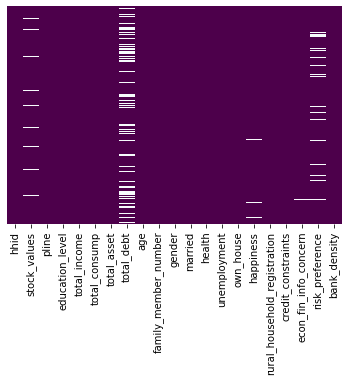

In [200]:
#Data visualization for the missing values
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [201]:
#Delete rows with too many missing values
data = data.dropna(subset = ['total_debt'])
data = data.dropna(subset = ['risk_preference'])
data = data.dropna(subset = ['stock_values'])
data = data.dropna(subset = ['happiness'])

In [202]:
data.isna().sum()

hhid                             0
stock_values                     0
pline                            0
education_level                 36
total_income                     0
total_consump                    0
total_asset                      0
total_debt                       0
age                              6
family_member_number             3
gender                           0
married                          0
health                           7
unemployment                     0
own_house                        0
happiness                        0
rural_household_registration     0
credit_constraints               0
econ_fin_info_concern           10
risk_preference                  0
bank_density                     0
dtype: int64

In [203]:
#Continue processing the missing values
data['education_level'] = data['education_level'].fillna(data['education_level'].median())
data['health'] = data['health'].fillna(data['health'].median())
data['family_member_number'] = data['family_member_number'].fillna(data['family_member_number'].median())
data['age'] = data['age'].fillna(data['age'].mean())
data['econ_fin_info_concern'] = data['econ_fin_info_concern'].fillna(data['econ_fin_info_concern'].median())

In fact, there is no restriction on the age of the head of the household, but since my research question requires the head of the household to be a person of `full civil capacity`, therefore I have set the age of the household head to be greater than or equal to `16` years old.

In addition, the number of data where the head of the household is less than 16 years old is very, very small and therefore deleted these data has little influence.

In [204]:
data = data.drop(data[data['age'] < 16].index)

<AxesSubplot:>

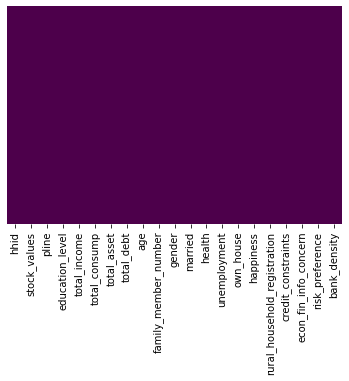

In [205]:
#All missing values have been processed
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [206]:
#Generate some needed variables
data["share_of_stock_asset"] = (data["stock_values"]/data["total_asset"])*100
data["age2"] = data["age"]*data["age"]

In [207]:
#Remove unneeded variables
del data["stock_values"]

In [208]:
data.describe()

,hhid,pline,education_level,total_income,total_consump,total_asset,total_debt,age,family_member_number,gender,...,unemployment,own_house,happiness,rural_household_registration,credit_constraints,econ_fin_info_concern,risk_preference,bank_density,share_of_stock_asset,age2
count,2.752000e+04,27520.000000,27520.000000,2.752000e+04,2.752000e+04,2.752000e+04,2.752000e+04,27520.000000,27520.000000,27520.000000,...,27520.000000,27520.000000,27520.000000,27520.000000,27520.000000,27520.000000,27520.000000,27520.000000,27519.000000,27520.000000
mean,1.766741e+09,1.559302,3.460029,1.011902e+05,6.811913e+04,1.141244e+06,7.216356e+04,52.698332,3.943750,0.172565,...,0.123728,0.923874,0.702253,0.568459,0.080923,1.042914,0.976308,0.088292,0.338673,2944.768155
std,6.233115e+08,0.982924,1.637127,2.154615e+05,8.350089e+04,2.181797e+06,2.901525e+05,12.948360,2.281196,0.377878,...,0.329277,0.265205,0.457276,0.495300,0.272722,1.093312,1.186772,0.099024,2.478971,1386.178519
min,2.011000e+08,1.000000,1.000000,-4.950324e+06,7.368000e+02,-2.124020e+05,0.000000e+00,16.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001606,0.000000,256.000000
25%,2.013010e+09,1.000000,2.000000,2.593070e+04,2.793850e+04,1.390455e+05,0.000000e+00,44.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035234,0.000000,1936.000000
50%,2.015004e+09,1.000000,3.000000,6.110460e+04,4.890800e+04,4.281965e+05,0.000000e+00,53.000000,3.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.059904,0.000000,2809.000000
75%,2.017004e+09,2.000000,4.000000,1.138700e+05,8.096000e+04,1.141810e+06,3.280625e+04,62.000000,5.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.098834,0.000000,3844.000000
max,2.017040e+09,20.000000,9.000000,8.497832e+06,3.434645e+06,6.394004e+07,1.690000e+07,117.000000,30.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,0.491327,72.723495,13689.000000


In [209]:
#Delete the unreasonable data of stock asset proportion greater than 100
data = data.drop(data[data['share_of_stock_asset'] > 100].index)

In [210]:
len(data)

27520

In [211]:
#Export data
data.to_csv(inputdir + 'processed_chfs_data.csv', index=False)